In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from bs4 import BeautifulSoup
import htmlmin

import pandas as pd

In [2]:
BAD_TAGS = {
    'script', 'style', 'meta', 'noscript', 'button'
}
BAD_ATTRIBUTES = {
    'class', "id", "name", "style", 'meta', 'href',
    'lang','language','onmouseover','onmouseout','script','font',
    'dir','face','size','color','width','height','hspace',
    'border','valign','align','background','bgcolor','text','link','vlink',
    'alink','cellpadding','cellspacing'
}

# Function to remove tags
def compress_html(html):
    # Remove spaces and new lines
    html = htmlmin.minify(html, remove_empty_space=True)

    # Remove bad tags
    soup = BeautifulSoup(html, "html.parser")
    for tag in BAD_TAGS:
        [x.extract() for x in soup.find_all(tag)]

    # Remove bad attributes
    all_attrs = BAD_ATTRIBUTES
    for tag in soup():
        for attr in tag.attrs:
            all_attrs.add(attr)

    for tag in soup():
        for attribute in all_attrs:
            del tag[attribute]

    # Substitute texts
    index = 0
    substituions = []
    for p in soup.find_all('p') + soup.find_all('cite'):
        _id = str(index)
        substituions.append(p.string)
        p.string = _id
        index += 1

    # Remove empty tags
    for tag in soup.find_all():
        if tag.text.strip() == '':
            tag.extract()
    with open('files/test/full_wiki_compressed.html', 'w+') as f:
        f.write(str(soup))
    return str(soup)

In [28]:
with open('files/test/full_wiki.html', 'r') as f:
    html = f.read()
print(len(html))

short_html = compress_html(html)

394896


In [23]:
df = pd.read_csv('files/top-1m.csv', header=None)
urls = np.array(['https://' + x for x in df[1].values.tolist()])
# urls = np.random.choice(urls, size=1000)
urls = urls[5000:10000]

In [24]:
COMPRESSION_TEST_URLS = [
    'https://en.wikipedia.org/wiki/ChatGPT',
    'https://stackoverflow.com/questions/5598524/can-i-remove-script-tags-with-beautifulsoup',
    'https://openai.com/product/gpt-4',
    'https://habr.com/ru/articles/327108/',
    'https://lmarkt.com/catalog/gitary/',
    'https://zhostovo-shop.ru/collection/all',
    'https://маркет.промыслы.рф/market'
]

In [25]:
from concurrent.futures import ThreadPoolExecutor

headers = {
    'sec-ch-ua': '"Chromium";v="112", "Google Chrome";v="112", "Not:A-Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
}


def fetch(url: str) -> list | None:
    try:
        response = requests.get(url, headers=headers, timeout=120)
        if response.status_code != 200:
            return None
        html = response.content.decode('utf-8')
        if len(html) == 0:
            return None
        compressed_html = compress_html(html)
        return [len(html), len(compressed_html)]
    except Exception as e:
        return None


def collect_statistics(urls: list[str]):
    with ThreadPoolExecutor(max_workers=50) as executor:
        results = list(tqdm(
            executor.map(fetch, urls),
            total=len(urls),
            bar_format="{desc:<5}{percentage:3.0f}%|{bar}{r_bar}",
            ncols=50
        ))
        results = [x for x in results if x]
    return results

In [5]:
import json

with open('files/output.json', 'r') as f:
    data = json.load(f)
len(data)

1099

In [47]:
data = collect_statistics(urls)
len(data)

       0%|               | 0/5000 [00:06<?, ?it/s]

KeyboardInterrupt



In [19]:
initial_sizes = np.array([r[0] for r in data if r[0] > 1000 and r[1] > 0])
compressed_sizes = np.array([r[1] for r in data if r[0] > 1000 and r[1] > 0])
compressed_ratio = initial_sizes / compressed_sizes
xdata = np.array([i for i in range(len(compressed_sizes))])

In [36]:
len(compressed_sizes[compressed_sizes < 5333]) / len(compressed_sizes)

0.8765652951699463

In [29]:
bins = [i for i in range(1, int(max(compressed_ratio)) + 1, 2)]
counts, bins = np.histogram(compressed_ratio, bins, density=True)

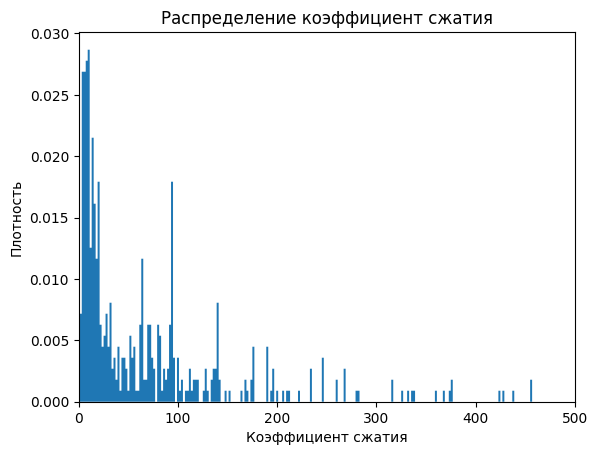

In [37]:
plt.stairs(counts, bins, fill=True)
plt.xlim(0, 500)
plt.xlabel('Коэффициент сжатия')
plt.ylabel('Плотность')
plt.title('Распределение коэффициент сжатия')
plt.savefig('figures/bins.png', dpi=300)

In [36]:
counts[1:].sum()  # Must be equal to initial size

371

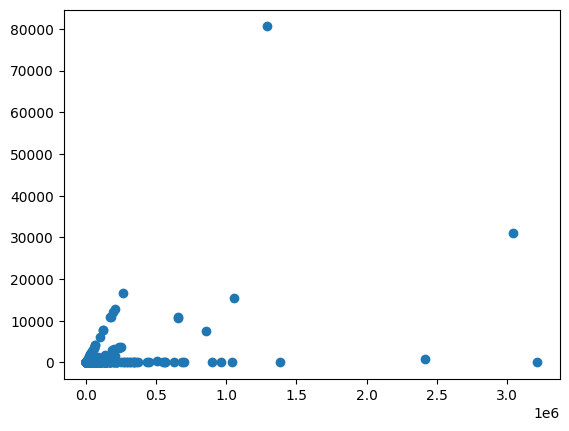

In [16]:
plt.scatter(initial_sizes, compressed_ratio)
plt.show()

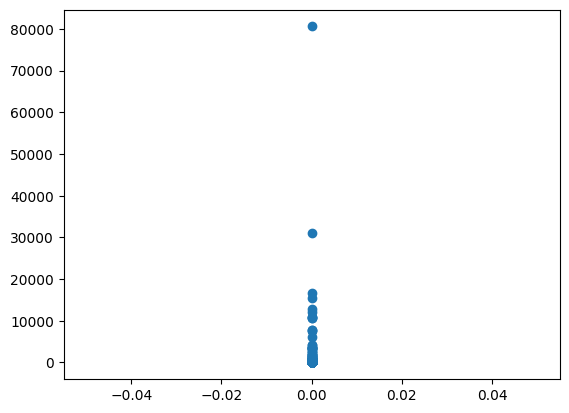

In [17]:
plt.scatter(np.zeros(len(compressed_ratio)), compressed_ratio)

<BarContainer object of 559 artists>

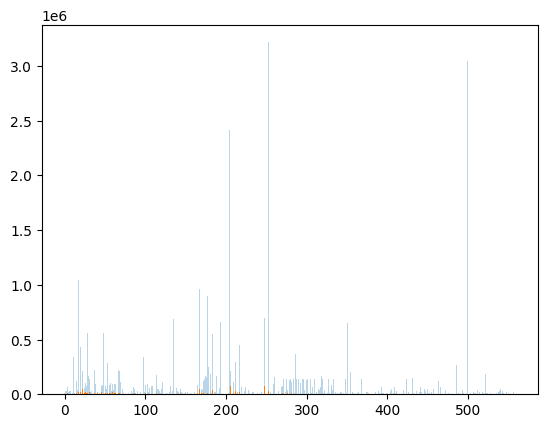

In [20]:
plt.bar(xdata, initial_sizes, alpha=0.3)
plt.bar(xdata, compressed_sizes)

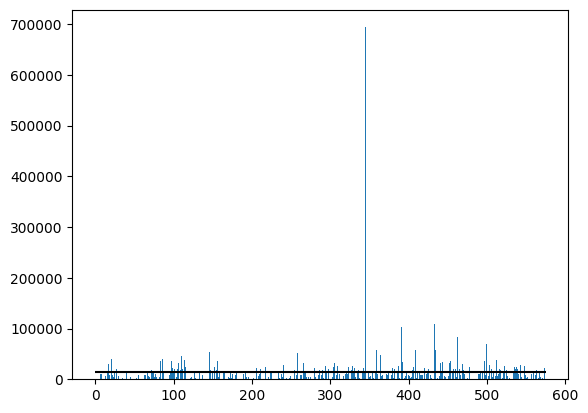

In [13]:
plt.bar(xdata, compressed_sizes)
plt.hlines(np.mean(compressed_sizes), xmin=0, xmax=len(xdata), color='black')

(0.0, 100.0)

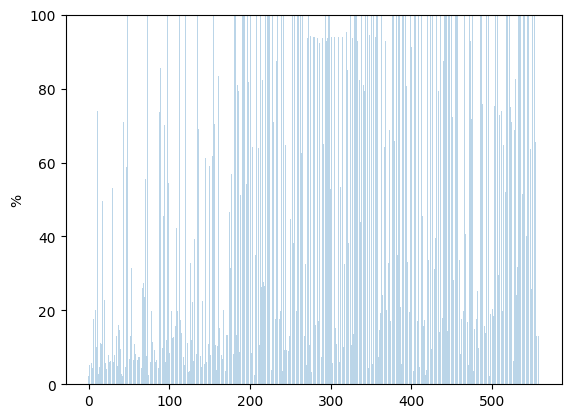

In [22]:
plt.bar(xdata, compressed_ratio, alpha=0.3)
plt.ylabel('%')
plt.ylim(0, 100)